### This is an interactive notebook for the malnutrition model, and running impact and cost modeling on a malnutrition intervention scenario. 
* The output for this intervention example is in raster
* The impact function shows the perturbed values for the number of malnutrition cases post intervention.
* The cost is the total cost of the intervention in USD.


In [1]:
import os
os.chdir("/usr/src/app")

In [2]:
!pip install pandas==1.0.0

In [2]:
import datetime, calendar
import pickle
import glob

import luigi
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import seaborn as sns
import hvplot.pandas
import holoviews as hv
import hvplot.xarray
import ipywidgets as widgets
from ipywidgets import Label, Layout,Text, HTML
import rasterio
import matplotlib.pyplot as plt

from models.malnutrition_model.tasks import HiResRasterMasked
from interventions.intervention_model import Intervention_provide
from luigi.parameter import DateIntervalParameter
from luigi.date_interval import Custom as CustomDateInterval

### Step 1. Get the indicator dataset. This can be provided manually by the user or generated from running a Luigi task
* The parameters specify here only affect the indicator dataset itself (not intervention).

In [3]:
# use interactive, not interact to easily access the input value!

slider_style = Layout(width='50%', height='30px')
descript_style = {'description_width': 'initial'}
year = widgets.IntSlider(description='Year:', orientation='horizontal',step=1, min=2010, max=2018, 
                         value=2018)
month1 = widgets.IntSlider(description='Starting Month: ', orientation='horizontal',step=1, min=1, max=12, 
                           value=5,style=descript_style, layout=slider_style)
month2 = widgets.IntSlider(description='Ending Month:', orientation='horizontal',step=1, min=1, max=12, 
                           value=7,style=descript_style, layout=slider_style)

def input_val(x):
    return str(x)

yr_wd = widgets.interactive(input_val, x=year)
display(yr_wd)

month1_wd = widgets.interactive(input_val, x=month1)
display(month1_wd)

month2_wd = widgets.interactive(input_val, x=month2)
display(month2_wd)

country_wd = widgets.Dropdown(
    options=['Ethiopia', 'South Sudan'],
    description='Country:',
    disabled=False,
)
display(country_wd)

scn_wd = widgets.Dropdown(
    options=['low', 'high', 'normal'],
    description='Rainfall scenario:',
    disabled=False,
    style=descript_style,
)
display(scn_wd)

interactive(children=(IntSlider(value=2018, description='Year:', max=2018, min=2010), Output()), _dom_classes=…

interactive(children=(IntSlider(value=5, description='Starting Month: ', layout=Layout(height='30px', width='5…

interactive(children=(IntSlider(value=7, description='Ending Month:', layout=Layout(height='30px', width='50%'…

Dropdown(description='Country:', options=('Ethiopia', 'South Sudan'), value='Ethiopia')

Dropdown(description='Rainfall scenario:', options=('low', 'high', 'normal'), style=DescriptionStyle(descripti…

In [4]:
timepoint = yr_wd.result+'-'+month1_wd.result.zfill(2)+'-01-'+yr_wd.result+'-'+month2_wd.result.zfill(2)+'-01'

In [5]:
rain_month = str(int(month2_wd.result)-1)
rainfall_time = yr_wd.result+'-'+rain_month.zfill(2)+'-01-'+yr_wd.result+'-'+month2_wd.result.zfill(2)+'-01'

#### Run the model based on User defined input in a luigi task.
* for this luigi task, `country_level` refers to the country of interest.
* `geography` is the geographical coverage for the output.
* `rainfall_scenario_geography` is an arbitrary AOI for rainfall scenario (must be within `geography`.
* `rainfall_scenario_time` is an arbitrary time interval for the rainfall scenario (must be within `time`)

In [6]:
# for Ethiopia, define geography
eth_geo_file = {"coordinates": [[[36.357226629663501, 14.272502682267801],[37.2970544510355, 14.6772882598167],[37.719862777828297, 15.0348782791802],[38.406926308866502, 14.8050668691039],[40.0981596160373, 14.4726873923002],[41.630839800661001, 13.4982974690825],[42.529307495095502, 12.365084475553299],[41.921520525330997, 11.1750924233907],[42.925690301463703, 11.1750924233907],[43.004966862737298, 10.578226842108799],[44.141264240992797, 9.224600687836],[47.033937477102299, 8.239013541804599],[48.343304299598302, 8.21360385046173],[45.151070168399599, 4.73902070129281],[43.621706074706402, 4.59611835261279],[42.379097748580598, 3.85735258666634],[41.255970992274698, 3.73813341072871],[40.730252085067598, 4.02423122213936],[39.631021642725599, 3.30881385146286],[38.8185469679511, 3.30881385146286],[38.029968607140503, 3.42808897514322],[36.906841850834503, 4.19107567031119],[35.9031966643484, 4.28639946386431],[35.568648268853003, 5.04853993824516],[35.042929361645903, 5.23894050051229],[34.732277280114502, 6.38005314679845],[32.772779535070001, 7.87384558608177],[33.035638988673597, 8.583349846796411],[33.872009977412098, 8.65422922148511],[34.134869431015602, 10.656535086660901],[36.357226629663501, 14.272502682267801]]], "type": "Polygon"}

In [7]:
MalnutritionInference = HiResRasterMasked(
    time=DateIntervalParameter().parse(timepoint),
    rainfall_scenario=scn_wd.value,
    country_level=country_wd.value,
    geography=eth_geo_file, 
    rainfall_scenario_geography= eth_geo_file,
    rainfall_scenario_time=DateIntervalParameter().parse(rainfall_time),
)

In [8]:
luigi.build([MalnutritionInference], local_scheduler=True, no_lock=True)

[2021-02-08 22:41:50,674] INFO [luigi:75] logging configured via *.conf file
[2021-02-08 22:41:50,686] INFO [luigi-interface:103] ExpiringLocalTarget 'output/intermediate/models.malnutrition_model.tasks.HiResRasterMasked_admin2_False_Ethiopia_9b92869980/_9b92869980.pickle' expired 2935828s ago at 2021-01-05 23:11:22.018420+00:00 and has been removed
[2021-02-08 22:41:50,693] INFO [luigi-interface:103] ExpiringLocalTarget 'output/intermediate/models.malnutrition_model.tasks.HighResMalnRaster_admin2_False_Ethiopia_9b92869980' expired 2932829s ago at 2021-01-06 00:01:21.690510+00:00 and has been removed
[2021-02-08 22:41:50,698] INFO [luigi-interface:587] Informed scheduler that task   models.malnutrition_model.tasks.HiResRasterMasked_admin2_False_Ethiopia_9b92869980   has status   PENDING
[2021-02-08 22:41:50,704] INFO [luigi-interface:103] ExpiringLocalTarget 'output/intermediate/models/malnutrition_model/tasks/MalnutritionRaster/MalnutritionRaster_admin2_False_Ethiopia_9b92869980.pickl

True

### Step 2. Run intervention impact on the output of the luigi task. Define the following parameters to instantiate an intervention scenario.

For geojson data, it needs to have specified feature names pointing to the indicator data corresponding to `indicator_col` and timestamp corresponding to `period_col` in `Intervention_model()`.

For the `provide_type` argument, the options are `Free food distribution`,`Supplementary feeding`, `School feeding` and `vaccine`.

The intervention model requires 2 sets of input parameters.
* The Greek alphabets defined the intrinsic property of the intervention (the default values are set according to `provide_type`.
  *  alpha1: placebo effect (e.g 0.1 for food, 0 for vaccine) 
  *  beta1: impact for first round (between 0-1)
  *  beta2: slope impact per increase in quantity of treatments(between 0-1)
  *  beta3: slope impact per increase in an unit of treatment (not to exceed 1)
  *  delta1: decay of the treatment efficiency over time (between 0-1)
  *  gamma2: exponent decay per increase in quantity of treatments as time goes by (between 0-1)
  *  gamma3: exponent decay of the increase per unit dose in time. (between 0-1)
* The other parameters are related to the scale of the intervention
  * q1: number of recipients per round of intervention
  * q2: number of intervention events (integer). It needs to correspond to reporting_dur
  * q3: quantity of treatment/transaction for one round of intervention
  * q3_1 to q3_4: the suffix refer to the different items in one unit of treament for one round of intervention (this is for estimating the total cost)
  * q3_norm: normalized dose/treatment delivery efficiency
  * interv_window: frequency of the intervention (e.g. every 7 days)
  * reporting_dur: total duration of the intervention period (approximately q2 * interv_window)

In [9]:
# path of the file
maln_target = MalnutritionInference.output().path
print(maln_target)

output/intermediate/models.malnutrition_model.tasks.HiResRasterMasked_admin2_False_Ethiopia_9b92869980/_9b92869980.pickle


In [10]:
cost_fname='https://darpa-output-dev.s3.amazonaws.com/final_targets/cost1_reg_output_4c717b2e0d.pickle'


In [11]:
free_food=Intervention_provide(indicator_col='gam_number',
                             admin_level='admin2',
                             provide_type='Free food distribution',
                             period_col='start')

impact_effect, impact_cost=free_food.impact_calculation(source_fname=maln_target,
                                           q1=1000, q2=4*2,q3=2,
                                           q3_1=2,q3_2=0, 
                                           q3_3=0, q3_4=0,
                                           q3_norm=1,
                                           interv_window=7,
                                           reporting_dur=30*2,)

In [12]:
output_2month=impact_effect

In [15]:
!pwd

/usr/src/app


In [16]:
#optional
output_2month.drop('dose day').to_netcdf(path="notebooks/malnutrition_intervention_2mo.nc",
                                         engine="h5netcdf", invalid_netcdf=True)


### Plot the map to visualize difference of baseline vs post-intervention

#### slice the xarray every 7 day for visualization

In [17]:
output_2month=output_2month.drop('dose day')
result_7d=output_2month.isel(period=slice(0, output_2month.dims['period'], 7))
type(result_7d)

xarray.core.dataset.Dataset

In [18]:
diff=np.log(result_7d['indicator']-result_7d['intervention']+1)

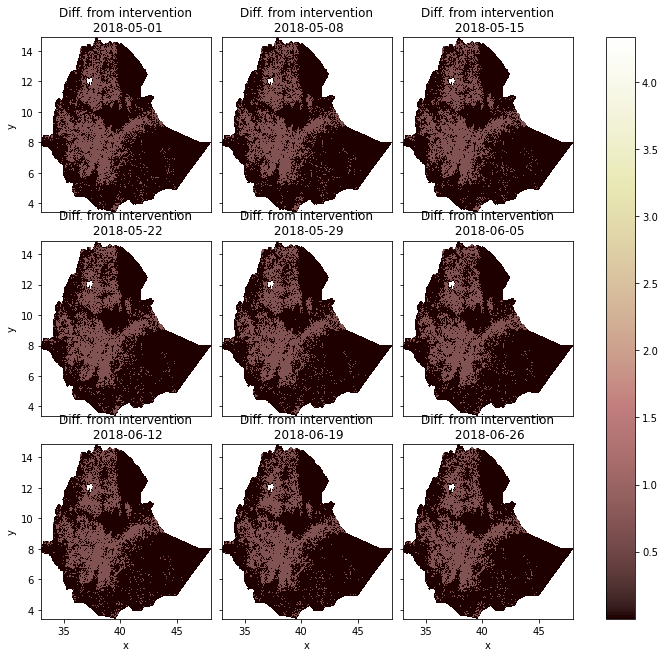

In [19]:
g=xr.plot.pcolormesh(diff, 'x', 'y', 
                     cmap='pink', col='period', col_wrap=3)
for i, ax in enumerate(g.axes.flat):
    tp=pd.to_datetime(diff['period'].data[i]).date()
    ax.set_title('Diff. from intervention\n {}'.format(tp))

/opt/conda/lib/python3.8/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/opt/conda/lib/python3.8/site-packages/xarray/core/computation.py:604: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


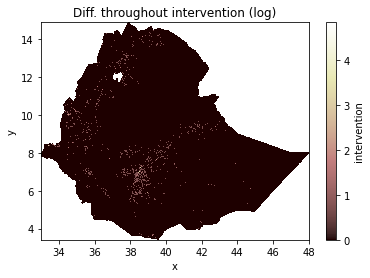

In [20]:
# look at difference within the intervention duration
xr.plot.pcolormesh(np.log(result_7d['intervention'][1]-result_7d['intervention'][8]+1),
cmap='pink')
plt.title('Diff. throughout intervention (log)');

In [5]:
# optional, save to s3 bucket
import boto3
s3 = boto3.resource('s3')
BUCKET = 'darpa-output-dev'
#malnutrition_9fc9c6c5d9_input.geojson
s3.Bucket(BUCKET).upload_file("../notebooks/malnutrition_intervention_2mo.nc", 
                              "final_targets/malnutrition_intervention_2mo.nc",
                             ExtraArgs={'ACL':'public-read'})
